# SKLearn Spacy Reddit Text Classification Example

In this example we will be buiding a text classifier using the reddit content moderation dataset.

For this, we will be using SpaCy for the word tokenization and lemmatization. 

The classification will be done with a Logistic Regression binary classifier.

For more information please visit: https://towardsdatascience.com/real-time-stream-processing-for-machine-learning-at-scale-with-spacy-kafka-seldon-core-6360f2fedbe

The steps in this tutorial include:

1) Train and build your NLP model

2) Build your containerized model

3) Test your model as a docker container

4) Run Seldon in your kubernetes cluster

5) Deploy your model with Seldon

6) Interact with your model through API

7) Clean your environment


## Before you start
Make sure you install the following dependencies, as they are critical for this example to work:

* Helm v3.0.0+
* A Kubernetes cluster running v1.13 or above (minkube / docker-for-windows work well if enough RAM)
* kubectl v1.14+
* Python 3.6+
* Python DEV requirements (we'll install them below)

Let's get started! 🚀🔥

## 1) Train and build your NLP model

In [1]:
%%writefile requirements.txt
scikit-learn>=0.23.2
spacy==2.3.2
dill==0.3.2
pandas==1.1.1

Overwriting requirements.txt


In [ ]:
!pip install -r requirements.txt

In [ ]:
!python -m spacy download en_core_web_sm

In [4]:
import os
import sys

import dill
import numpy as np
import pandas as pd

# This import may take a while as it will download the Spacy ENGLISH model
from ml_utils import CleanTextTransformer, SpacyTokenTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from seldon_core.seldon_client import SeldonClient

In [5]:
df_cols = ["prev_idx", "parent_idx", "body", "removed"]

TEXT_COLUMN = "body"
CLEAN_COLUMN = "clean_body"
TOKEN_COLUMN = "token_body"

# Downloading the 50k reddit dataset of moderated comments
df = pd.read_csv(
    "https://raw.githubusercontent.com/axsauze/reddit-classification-exploration/master/data/reddit_train.csv",
    names=df_cols,
    skiprows=1,
    encoding="ISO-8859-1",
)

df.head()

,prev_idx,parent_idx,body,removed
0,8756,8877,Always be wary of news articles that cite unpu...,0
1,7330,7432,The problem I have with this is that the artic...,0
2,15711,15944,"This is indicative of a typical power law, and...",0
3,1604,1625,This doesn't make sense. Chess obviously trans...,0
4,13327,13520,1. I dispute that gene engineering is burdenso...,0


In [ ]:
!pip install matplotlib

<AxesSubplot:>

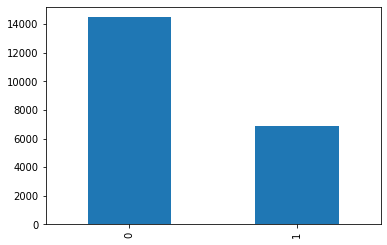

In [7]:
# Let's see how many examples we have of each class
df["removed"].value_counts().plot.bar()

In [8]:
x = df["body"].values
y = df["removed"].values
x_train, x_test, y_train, y_test = train_test_split(
    x, y, stratify=y, random_state=42, test_size=0.1, shuffle=True
)

In [9]:
# Clean the text
clean_text_transformer = CleanTextTransformer()
x_train_clean = clean_text_transformer.transform(x_train)

In [10]:
# Tokenize the text and get the lemmas
spacy_tokenizer = SpacyTokenTransformer()
x_train_tokenized = spacy_tokenizer.transform(x_train_clean)

In [11]:
# Build tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    preprocessor=lambda x: x,
    tokenizer=lambda x: x,
    token_pattern=None,
    ngram_range=(1, 3),
)

tfidf_vectorizer.fit(x_train_tokenized)

TfidfVectorizer(max_features=10000, ngram_range=(1, 3),
                preprocessor=<function <lambda> at 0x7f709e273a70>,
                token_pattern=None,
                tokenizer=<function <lambda> at 0x7f709e2735f0>)

In [12]:
# Transform our tokens to tfidf vectors
x_train_tfidf = tfidf_vectorizer.transform(x_train_tokenized)

In [13]:
# Train logistic regression classifier
lr = LogisticRegression(C=0.1, solver="sag")
lr.fit(x_train_tfidf, y_train)

LogisticRegression(C=0.1, solver='sag')

In [14]:
# These are the models we'll deploy
with open("tfidf_vectorizer.model", "wb") as model_file:
    dill.dump(tfidf_vectorizer, model_file)
with open("lr.model", "wb") as model_file:
    dill.dump(lr, model_file)

## 2) Build your containerized model

In [15]:
%%writefile RedditClassifier.py
import dill

from ml_utils import CleanTextTransformer, SpacyTokenTransformer


class RedditClassifier(object):
    def __init__(self):

        self._clean_text_transformer = CleanTextTransformer()
        self._spacy_tokenizer = SpacyTokenTransformer()

        with open("tfidf_vectorizer.model", "rb") as model_file:
            self._tfidf_vectorizer = dill.load(model_file)

        with open("lr.model", "rb") as model_file:
            self._lr_model = dill.load(model_file)

    def predict(self, X, feature_names):
        clean_text = self._clean_text_transformer.transform(X)
        spacy_tokens = self._spacy_tokenizer.transform(clean_text)
        tfidf_features = self._tfidf_vectorizer.transform(spacy_tokens)
        predictions = self._lr_model.predict_proba(tfidf_features)
        return predictions

Overwriting RedditClassifier.py


In [16]:
# test that our model works
from RedditClassifier import RedditClassifier

# With one sample
sample = x_test[0:1]
print(sample)
print(RedditClassifier().predict(sample, ["feature_name"]))

['This is the study that the article is based on:\r\n\r\nhttps://www.nature.com/articles/nature25778.epdf']
[[0.82791781 0.17208219]]


### Create Docker Image with the S2i utility
Using the S2I command line interface we wrap our current model to seve it through the Seldon interface

In [17]:
%%writefile Dockerfile
FROM seldonio/seldon-core-s2i-python37-ubi8:1.7.0-dev

RUN pip install spacy==2.3.2
RUN python -m spacy download en_core_web_sm

Overwriting Dockerfile


In [ ]:
%%bash
docker build . -f Dockerfile -t seldonio/seldon-core-spacy-base:0.1

To create a docker image we need to creat s2i folder configuration as below:

In [19]:
!cat .s2i/environment

MODEL_NAME=RedditClassifier
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0


In [20]:
# As well as a requirements.txt file with all the relevant dependencies
!cat requirements.txt

scikit-learn>=0.23.2
spacy==2.3.2
dill==0.3.2
pandas==1.1.1


In [ ]:
%%bash
s2i build . seldonio/seldon-core-spacy-base:0.1 seldonio/reddit-classifier:0.1

## 3) Test your model as a docker container

In [22]:
# Remove previously deployed containers for this model
!docker rm -f reddit_predictor

Error: No such container: reddit_predictor


In [23]:
!docker run --name "reddit_predictor" -d --rm -p 9001:9000 seldonio/reddit-classifier:0.1

f11cbad41edbab69bbc692a61957648de98833b4aea4af5157ca192adf8c8eda


In [ ]:
!curl -v -X POST -H 'Content-Type: application/json' \
   -d '{"data": { "ndarray": ["this is a terrible comment"], "names": ["tfidf"] } }' \
    http://localhost:9001/api/v1.0/predictions

In [ ]:
# We now test the REST endpoint expecting the same result
endpoint = "0.0.0.0:9001"
batch = sample
payload_type = "ndarray"

sc = SeldonClient(microservice_endpoint=endpoint)
response = sc.microservice(
    data=batch, method="predict", payload_type=payload_type, names=["tfidf"]
)

print(response)

In [28]:
# We now stop it to run it in docker
!docker stop reddit_predictor

reddit_predictor


## 4) Run Seldon in your kubernetes cluster


### Setup Seldon Core

Use the setup notebook to [Setup Cluster](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Setup-Cluster) with [Ambassador Ingress](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Ambassador) or Istio and [Install Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Install-Seldon-Core). Instructions [also online](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html).

## 5) Deploy your model with Seldon
We can now deploy our model by using the Seldon graph definition:

In [29]:
%%writefile reddit_clf.json
{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "reddit-classifier"
    },
    "spec": {
        "annotations": {
            "project_name": "Reddit classifier",
            "deployment_version": "v1"
        },
        "name": "reddit-classifier",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/reddit-classifier:0.1",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                                    }
                                }
                            }
                        ],
                        "terminationGracePeriodSeconds": 20
                    }
                }],
                "graph": {
                    "children": [],
                    "name": "classifier",
                    "endpoint": {
            "type" : "REST"
            },
                    "type": "MODEL"
                },
                "name": "single-model",
                "replicas": 1,
        "annotations": {
            "predictor_version" : "v1"
        }
            }
        ]
    }
}

Overwriting reddit_clf.json


Note: if you are using kind preload image first with
```bash
kind load docker-image reddit-classifier:0.1 --name <name of your cluster>
```

In [30]:
!kubectl apply -f reddit_clf.json

seldondeployment.machinelearning.seldon.io/reddit-classifier created


In [31]:
!kubectl get pods

NAME                                                           READY   STATUS              RESTARTS   AGE
reddit-classifier-single-model-0-classifier-78d5cf779d-td25h   0/2     ContainerCreating   0          0s
seldon-92a927e5e90d7602e08ba9b9304f70e8-5bcf96696f-6pwbt       1/2     Running             2          3d5h


## 6) Interact with your model through API
Now that our Seldon Deployment is live, we are able to interact with it through its API.

There are two options in which we can interact with our new model. These are:

a) Using CURL from the CLI (or another rest client like Postman)

b) Using the Python SeldonClient

### a) Using CURL from the CLI

In [32]:
%%bash
curl -s -H 'Content-Type: application/json' \
    -d '{"data": {"names": ["text"], "ndarray": ["Hello world this is a test"]}}' \
    http://localhost:80/seldon/default/reddit-classifier/api/v1.0/predictions

### b) Using the Python SeldonClient

In [ ]:
import numpy as np

from seldon_core.seldon_client import SeldonClient

sc = SeldonClient(
    gateway="ambassador",
    transport="rest",
    gateway_endpoint="localhost:80",  # Make sure you use the port above
    namespace="default",
)

client_prediction = sc.predict(
    data=np.array(["Hello world this is a test"]),
    deployment_name="reddit-classifier",
    names=["text"],
    payload_type="ndarray",
)

print(client_prediction)

## 7) Clean your environment

In [35]:
!kubectl delete -f reddit_clf.json

seldondeployment.machinelearning.seldon.io "reddit-classifier" deleted
